Checking SNR of accumulated dephasing (detectability criterion from [accretion disk dephasing study](https://arxiv.org/abs/2005.11333)). Making a cut on this is equivalent to saying a system is discoverable if the likelihood ratio exceeds (ie ignoring the look-elsewhere effect).

In [9]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from corner import corner
from tqdm.auto import tqdm, trange
from math import sqrt

import jax
import jax.numpy as jnp
from jax import random

from pydd.binary import *
from pydd.analysis import *
from pydd.noise import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
m_1 = 1e3 * MSUN
m_2 = 1 * MSUN
rho_s = 226 * MSUN / PC**3
gamma_s = 7 / 3
f_l = jnp.array(0.022621092492458004)  # Hz

vb = make_vacuum_binary(m_1, m_2)
sd = make_static_dress(m_1, m_2, rho_s, gamma_s)
dd = make_dynamic_dress(m_1, m_2, rho_s, gamma_s)

When the dephasing is large ($c_f > 0$) this just reduces to the vacuum binary SNR. The best-fit vacuum binary parameters are also significantly different from the dark dress ones in that case, so this becomes meaningless.

In [6]:
@jit
def calculate_dephasing_SNR(dd: DynamicDress, vb: VacuumBinary, f_l):
    integrand = lambda f: 4 * amp_plus(f, vb)**2 * (
        2 * (1 - jnp.cos(Psi(f, vb) - Psi(f, dd)))
    ) / S_n_LISA(f)
    return jnp.sqrt(simps(integrand, f_l, dd.f_c, 100000, True))

In [36]:
print("SNR (v-d): ", calculate_dephasing_SNR(dd, vb, f_l))
print("SNR (d):   ", calculate_SNR(dd, f_l, dd.f_c, 30000))
print("SNR (v):   ", calculate_SNR(vb, f_l, vb.f_c, 30000))

SNR (v-d):  13.015637192011582
SNR (d):    9.193760960108461
SNR (v):    9.203580893239108


In [29]:
c_fs = jnp.linspace(0., 3e-7, 50)
dephasing_SNRs = []
for c_f in c_fs:
    dd_h = DynamicDress(
        dd.gamma_s,
        c_f,
        dd.M_chirp,
        dd.q,
        dd.Phi_c,
        dd.tT_c,
        dd.dL_iota,
        dd.f_c,
    )
    dephasing_SNRs.append(calculate_dephasing_SNR(dd_h, vb, f_l))

dephasing_SNRs = jnp.stack(dephasing_SNRs)

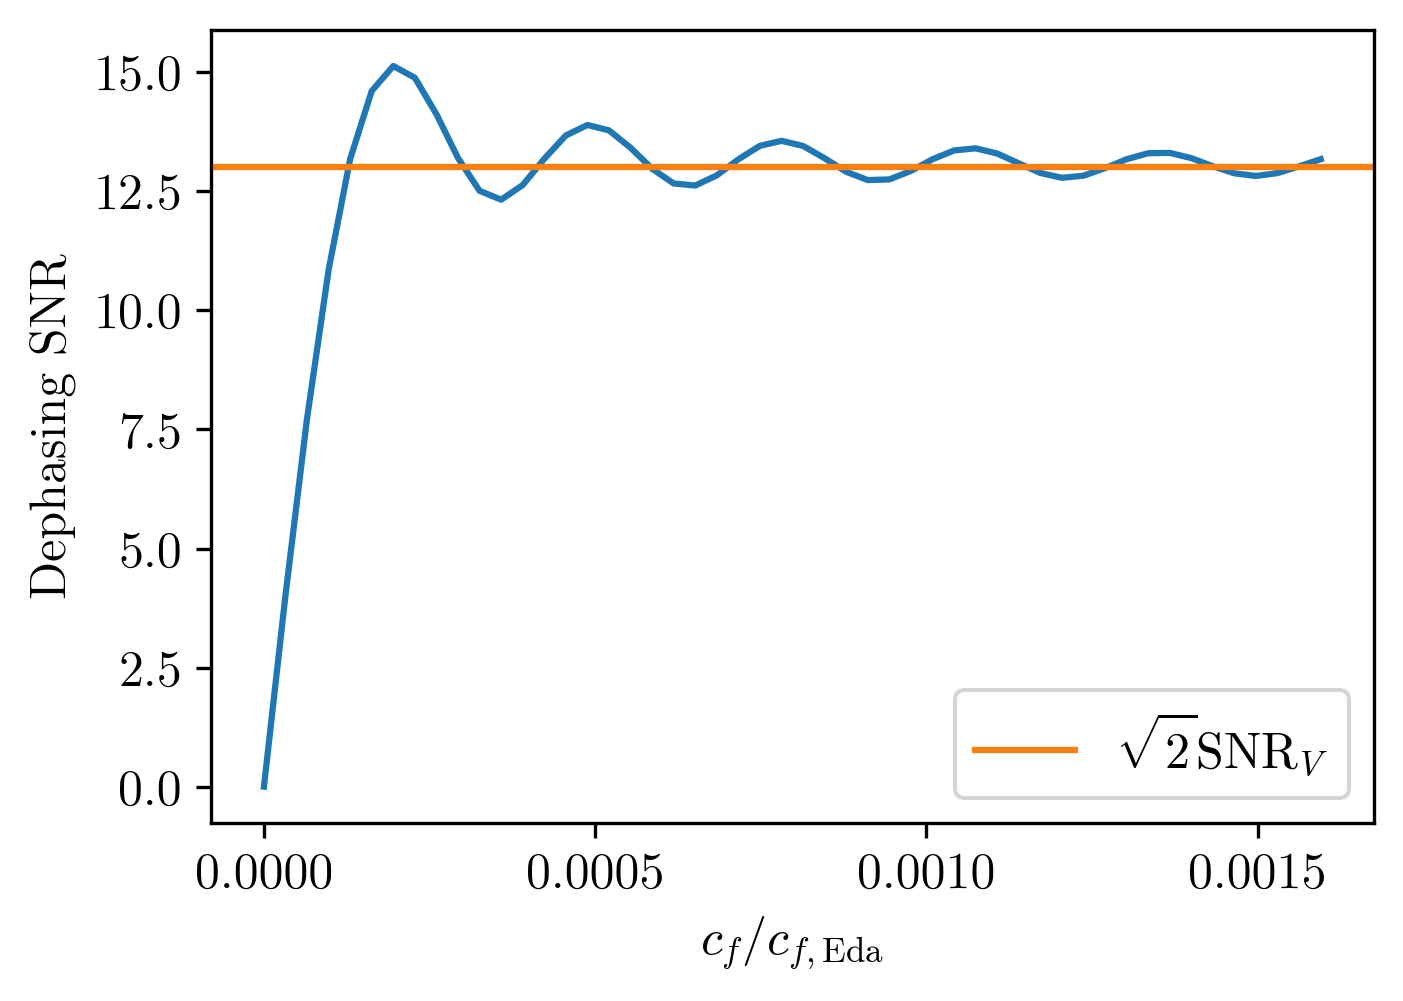

In [35]:
plt.plot(c_fs / dd.c_f, dephasing_SNRs)
plt.axhline(
    calculate_SNR(vb, f_l, vb.f_c, 30000) * sqrt(2),
    color="C1",
    label=r"$\sqrt{2} \mathrm{SNR}_V$"
)
plt.xlabel(r"$c_f / c_{f,\mathrm{Eda}}$")
plt.ylabel("Dephasing SNR")
plt.legend()
# plt.title(r"${c_f}_\mathrm{Eda} = %.5f$" % dd.c_f)